In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn.preprocessing import LabelEncoder
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1. Structure of Data Sets

In [4]:
print(train.shape)
train.tail()

(647054, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [6]:
print(test.shape)
test.tail()

(653646, 6)


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 6 columns):
VisitNumber              653646 non-null int64
Weekday                  653646 non-null object
Upc                      649660 non-null float64
ScanCount                653646 non-null int64
DepartmentDescription    652318 non-null object
FinelineNumber           649660 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 29.9+ MB


# 2. Columns

|        Columns        | Data Type |                                                     Description                                                     | Unique value |
|:---------------------:|:---------:|:-------------------------------------------------------------------------------------------------------------------:|:------------:|
|        TripType       |   int64   | 우리가 예측해야할것. 손님들의 쇼핑 타입을 나타냄. 각각의 숫자가 어떤 trip type인지에 대한 설명은 없음. 999번은 기타 |      38      |
|      VisitNumber      |   int64   | 한 사람의 손님을 나타내는 id(이에 해당하는 trip type도 하나)                                                        |     95674    |
|        Weekday        |   object  | 요일(월 ~ 일요일)                                                                                                   |       7      |
|          Upc          |  float64  | 구매한 물건의 UPC(Universal Product Code)                                                                           |     97715    |
|       ScanCount       |   int64   | 해당물건을 몇개 구입했는지 나타냄. 음수는 환불했음을 의미함. -12 ~71 까지 있음. 평균은 1.1                          |      39      |
| DepartmentDescription |   object  | 해당 물건의 상위레벨 분류. 마트의 코너 개념                                                                         |      69      |
|     FinelineNumber    |  float64  | Walmart에서 분류한 해당 물건의 좀 더 상세한 분류                                                                    |     5196     |

|        Columns        | Data Type |                          Description                              | Unique value |
|:---------------------:|:---------:|:-----------------------------------------------------------------:|:------------:|
|        TripType       |   int64   | - 우리가 예측해야할것                                             |      38      |
|                       |           | - 손님들의 쇼핑 타입을 나타냄                                     |              |
|                       |           | - 각각의 숫자가 어떤 trip type인지에 대한 설명은 없음             |              |
|                       |           | - 999번은 기타                                                    |              |
|      VisitNumber      |   int64   | - 한 사람의 손님을 나타내는 id                                    |     95674    |
|                       |           | - 이에 해당하는 trip type도 하나                                  |              |
|        Weekday        |   object  | - 요일(월 ~ 일요일)                                               |       7      |
|          Upc          |  float64  | - 구매한 물건의 UPC(Universal Product Code)                       |     97715    |
|       ScanCount       |   int64   | - 해당물건을 몇개 구입했는지 나타냄                               |      39      |
|                       |           | - 음수는 환불했음을 의미함                                        |              |
|                       |           | - -12 ~71 까지 있음                                               |              |
|                       |           | - 평균은 1.1                                                      |              |
| DepartmentDescription |   object  | - 해당 물건의 상위레벨 분류                                       |      69      |
|                       |           | - 마트의 코너 개념                                                |              |
|     FinelineNumber    |  float64  | - Walmart에서 분류한 해당 물건의 좀 더 상세한 분류                |     5196     |

# 3. Feature Engineering

### 3-1. Missing Data
- Upc : 4192개
- DepartmentDescription : 1361개
- FinelineNumber : 4129개

In [12]:
len(train["Upc"][train["Upc"].isnull()])

4129

In [13]:
len(train["DepartmentDescription"][train["DepartmentDescription"].isnull()])

1361

In [14]:
len(train["FinelineNumber"][train["FinelineNumber"].isnull()])

4129

- Upc, DepartmentDescription, FinelineNumber가 모두 null인 row가 1361개

In [39]:
Upc_null = set(train["Upc"][train["Upc"].isnull()].index)
dd_null = set(train["DepartmentDescription"][train["DepartmentDescription"].isnull()].index)
fn_null = set(train["FinelineNumber"][train["FinelineNumber"].isnull()].index)
udf_null = list(Upc_null & dd_null & fn_null)
len(udf_null)

1361

In [50]:
null_df = train.loc[udf_null, ["TripType"]]

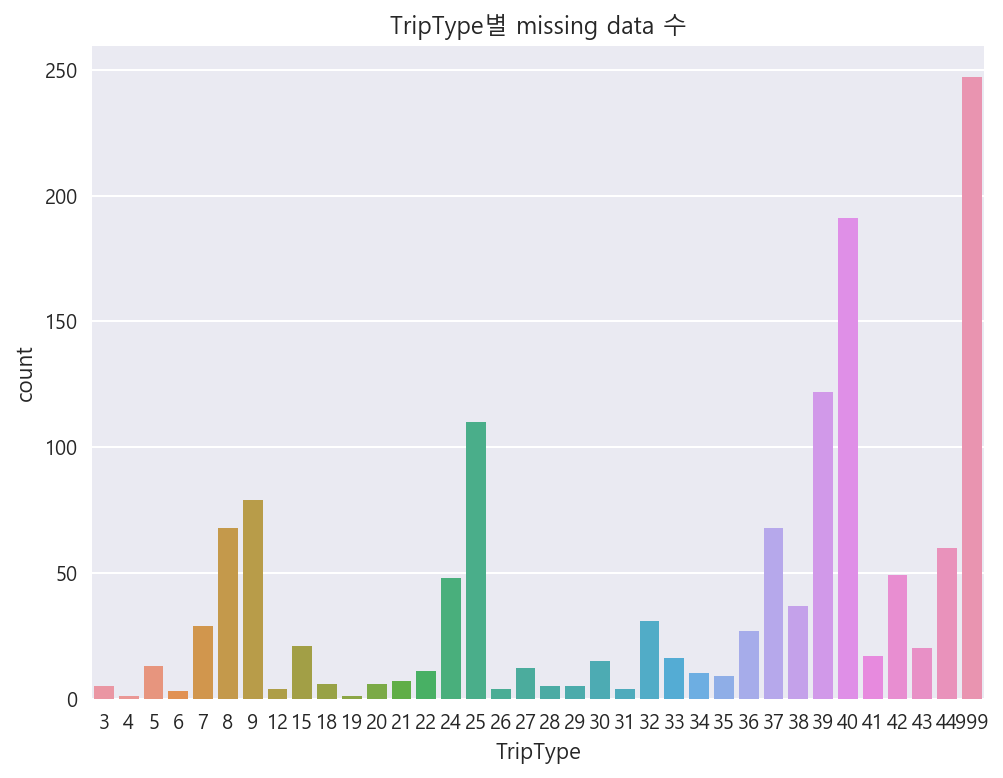

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(null_df['TripType'])
plt.title("TripType별 missing data 수")
plt.show()

### 3-2. Decoding UPCs

- About UPC(Universal Product Code) 

![Alt text](UPC_and_EAN.jpg)

- 주어진 UPC들의 길이
    - 1 ~ 12자리 까지 주어짐
    - 10자리와 11자리가 제일 많음
    - 1자리로된 UPC는 missing value로 처리함

In [8]:
c = [4129, 7, 29745, 372, 1, 412, 2166, 433341, 168418, 8463]
length_of_UPC = pd.DataFrame({"Length":[1,3,4,5,7,8,9,10,11,12]})
length_of_UPC["Count"] = c
length_of_UPC

,Length,Count
0,1,4129
1,3,7
2,4,29745
3,5,372
4,7,1
5,8,412
6,9,2166
7,10,433341
8,11,168418
9,12,8463


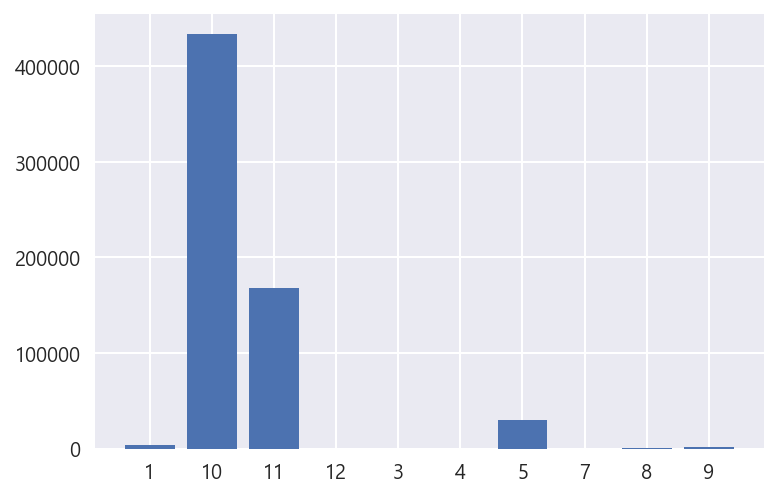

In [9]:
plt.bar(length_of_UPC["Length"].astype(str), length_of_UPC["Count"])
plt.show()

- Decoding UPCs

![Alt text](Decoding_UPCs_2.jpg)

In [10]:
# Check digit 추가하는 함수
def get_checkdigit(upc):
    
    odd_s = [int(i) for i in str(upc)[-1::-2]]
    even_s = [int(i) for i in str(upc)[-2::-2]]
    
    odd_sum = sum(list(map(lambda number : number * 3, odd_s)))
    even_sum = sum(list(map(lambda number : number, even_s)))
    check_sum = (odd_sum + even_sum) % 10
    

    if check_sum == 0:
        return check_sum
    else:
        return 10 - check_sum

In [11]:
# UPC길이를 12자리로 만드는 함수
def make_full_upc(upc):
    if upc == 0:
        return "missing"
    else:
        tmp_upc = str(upc) + str(get_checkdigit(upc))


        if len(tmp_upc) < 12:
            length = 12 - len(tmp_upc)
            zero = "0" * length
            standard_upc = zero + tmp_upc
            return standard_upc
        else:
            return tmp_upc 

In [12]:
# Company code와 Product code 추출
def classify_company_product(standard_upc):
    class_ = []
    
    if standard_upc == "missing":
        return standard_upc
    
    elif len(standard_upc) == 13:
        company = standard_upc[2:7]
        product = standard_upc[7:12]
        
        class_.append(company)
        class_.append(product)
        return class_
    
    # len = 12
    else: 
        if standard_upc[:6] == "000000":
            company = standard_upc[-6:-3]
            product = standard_upc[-3:-1]
            class_.append(company)
            class_.append(product)
            return class_
        else:
            company = standard_upc[1:6]
            product = standard_upc[6:11]

            class_.append(company)
            class_.append(product)
            return class_

In [13]:
# 추출한 Company code와 Product code로 각각의 column 만들기
def make_company_col(tmp):
    if tmp == "missing":
        return tmp
    else:
        return tmp[0]

def make_product_col(tmp):
    if tmp == "missing":
        return tmp
    else:
        return tmp[1]

# data['company_code'] = data['tmp'].apply(make_company_col)
# data['product_code'] = data['tmp'].apply(make_product_col)

### 3-3. FinelineNumber, DepartmentDescription, company_code, product_code

- 상품별 평균 판매량이 일정 수치 **이상**인 상품 제거 ( 모든 고객이 공통적으로 구매하는 상품)
- 남아 있는 상품 중, **TripType** 별로 1개 이상 구매한 **상품 리스트**체크
- **상품 리스트**에 있는 상품을 각 고객이 산 갯수 카운트

In [57]:
train_v1 = pd.read_csv("train_v1.csv")
train_le = train_v1.copy()
le = LabelEncoder()
dd_le = le.fit_transform(list(train_le["DepartmentDescription"]))
train_le["DepartmentDescription"] = dd_le
fn_le = le.fit_transform(list(train_le["FinelineNumber"]))
train_le["FinelineNumber"] = fn_le
cc_le = le.fit_transform(list(train_le["company_code"]))
train_le["company_code"] = cc_le
pc_le = le.fit_transform(list(train_le["product_code"]))
train_le["product_code"] = pc_le

In [15]:
gb = train_le.groupby(by=["TripType", "DepartmentDescription"]).size()
gb = pd.DataFrame(gb)
gb.rename(columns={0:"Count"}, inplace=True)

In [16]:
tt_list = train["TripType"].unique()

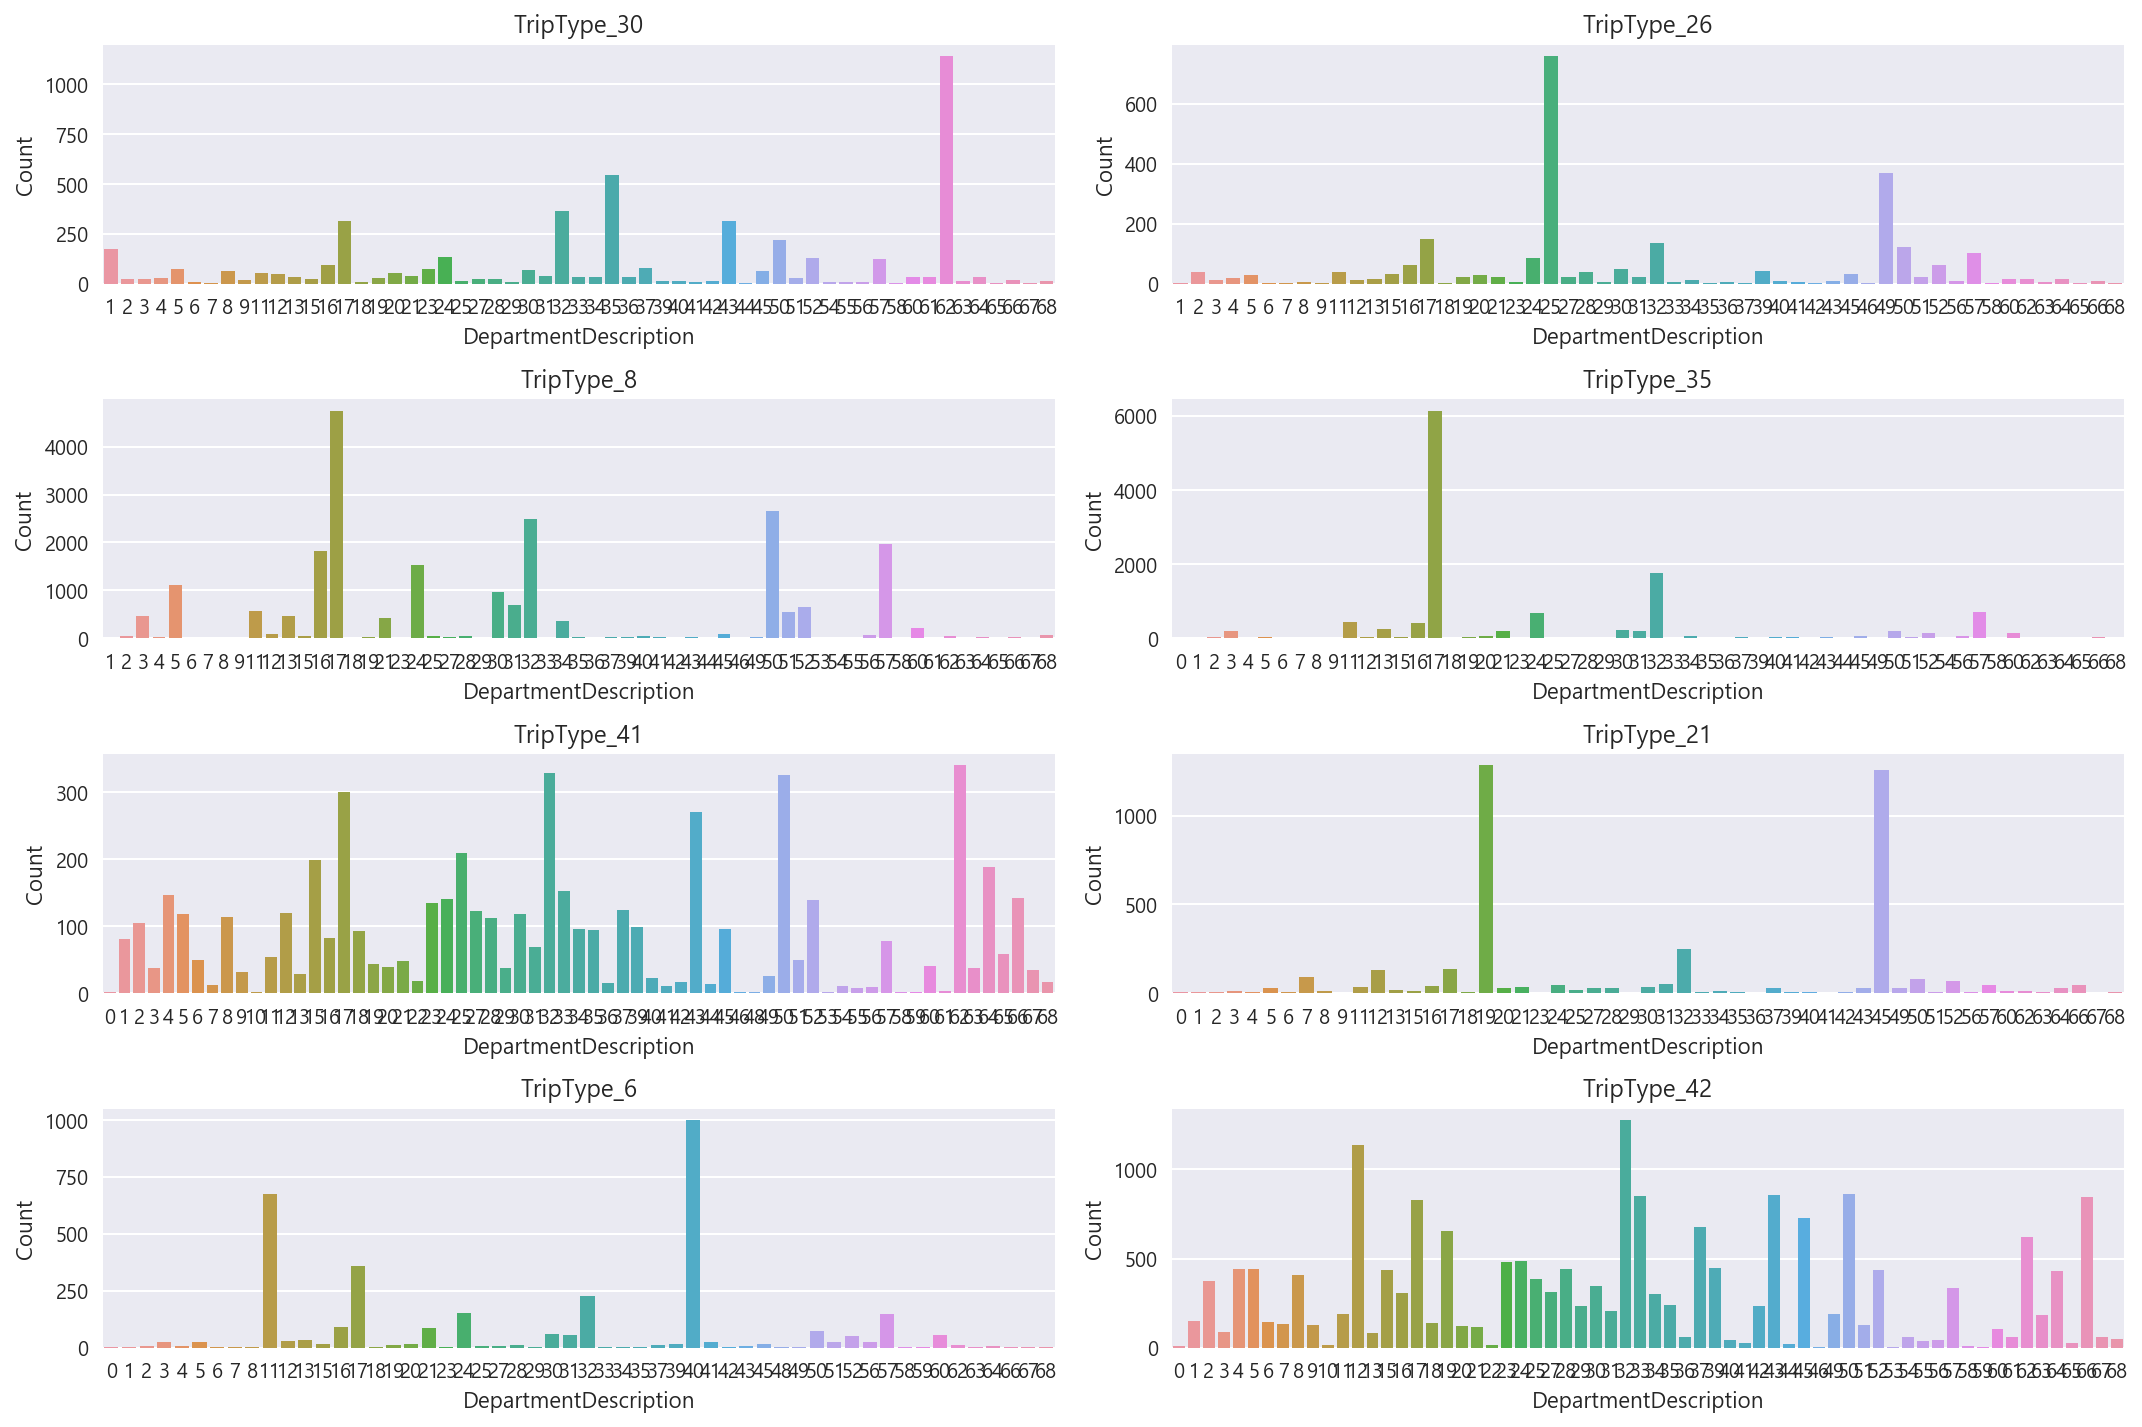

In [17]:
plt.figure(figsize=(15,10))
for i in range(1, 9):
    a = '42' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb.loc[tt].index,y=gb.loc[tt]["Count"], data=gb.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [18]:
mhd = pd.read_csv('Musthave_by_DepartmentDescription.csv')
mhd.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191343,0.0,3.0,9.0,9.0,3.0,3.0,9.0,9.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0
95670,191344,5.0,4.0,4.0,5.0,5.0,4.0,1.0,4.0,0.0,...,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,0.0
95671,191345,12.0,16.0,16.0,16.0,17.0,16.0,11.0,17.0,2.0,...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0
95672,191346,13.0,17.0,16.0,15.0,17.0,17.0,9.0,17.0,2.0,...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,2.0
95673,191347,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


In [19]:
train_le.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,52,1118.0
647050,39,191346,Sunday,7.874205e+09,1,21,1752.0
647051,39,191346,Sunday,4.072000e+03,1,57,4170.0
647052,8,191347,Sunday,4.190008e+09,1,16,1512.0
647053,8,191347,Sunday,3.800060e+09,1,24,3600.0


In [21]:
gb2 = train_le.groupby(by=["TripType", "FinelineNumber"]).size()
gb2 = pd.DataFrame(gb2)
gb2.rename(columns={0:"Count"}, inplace=True)

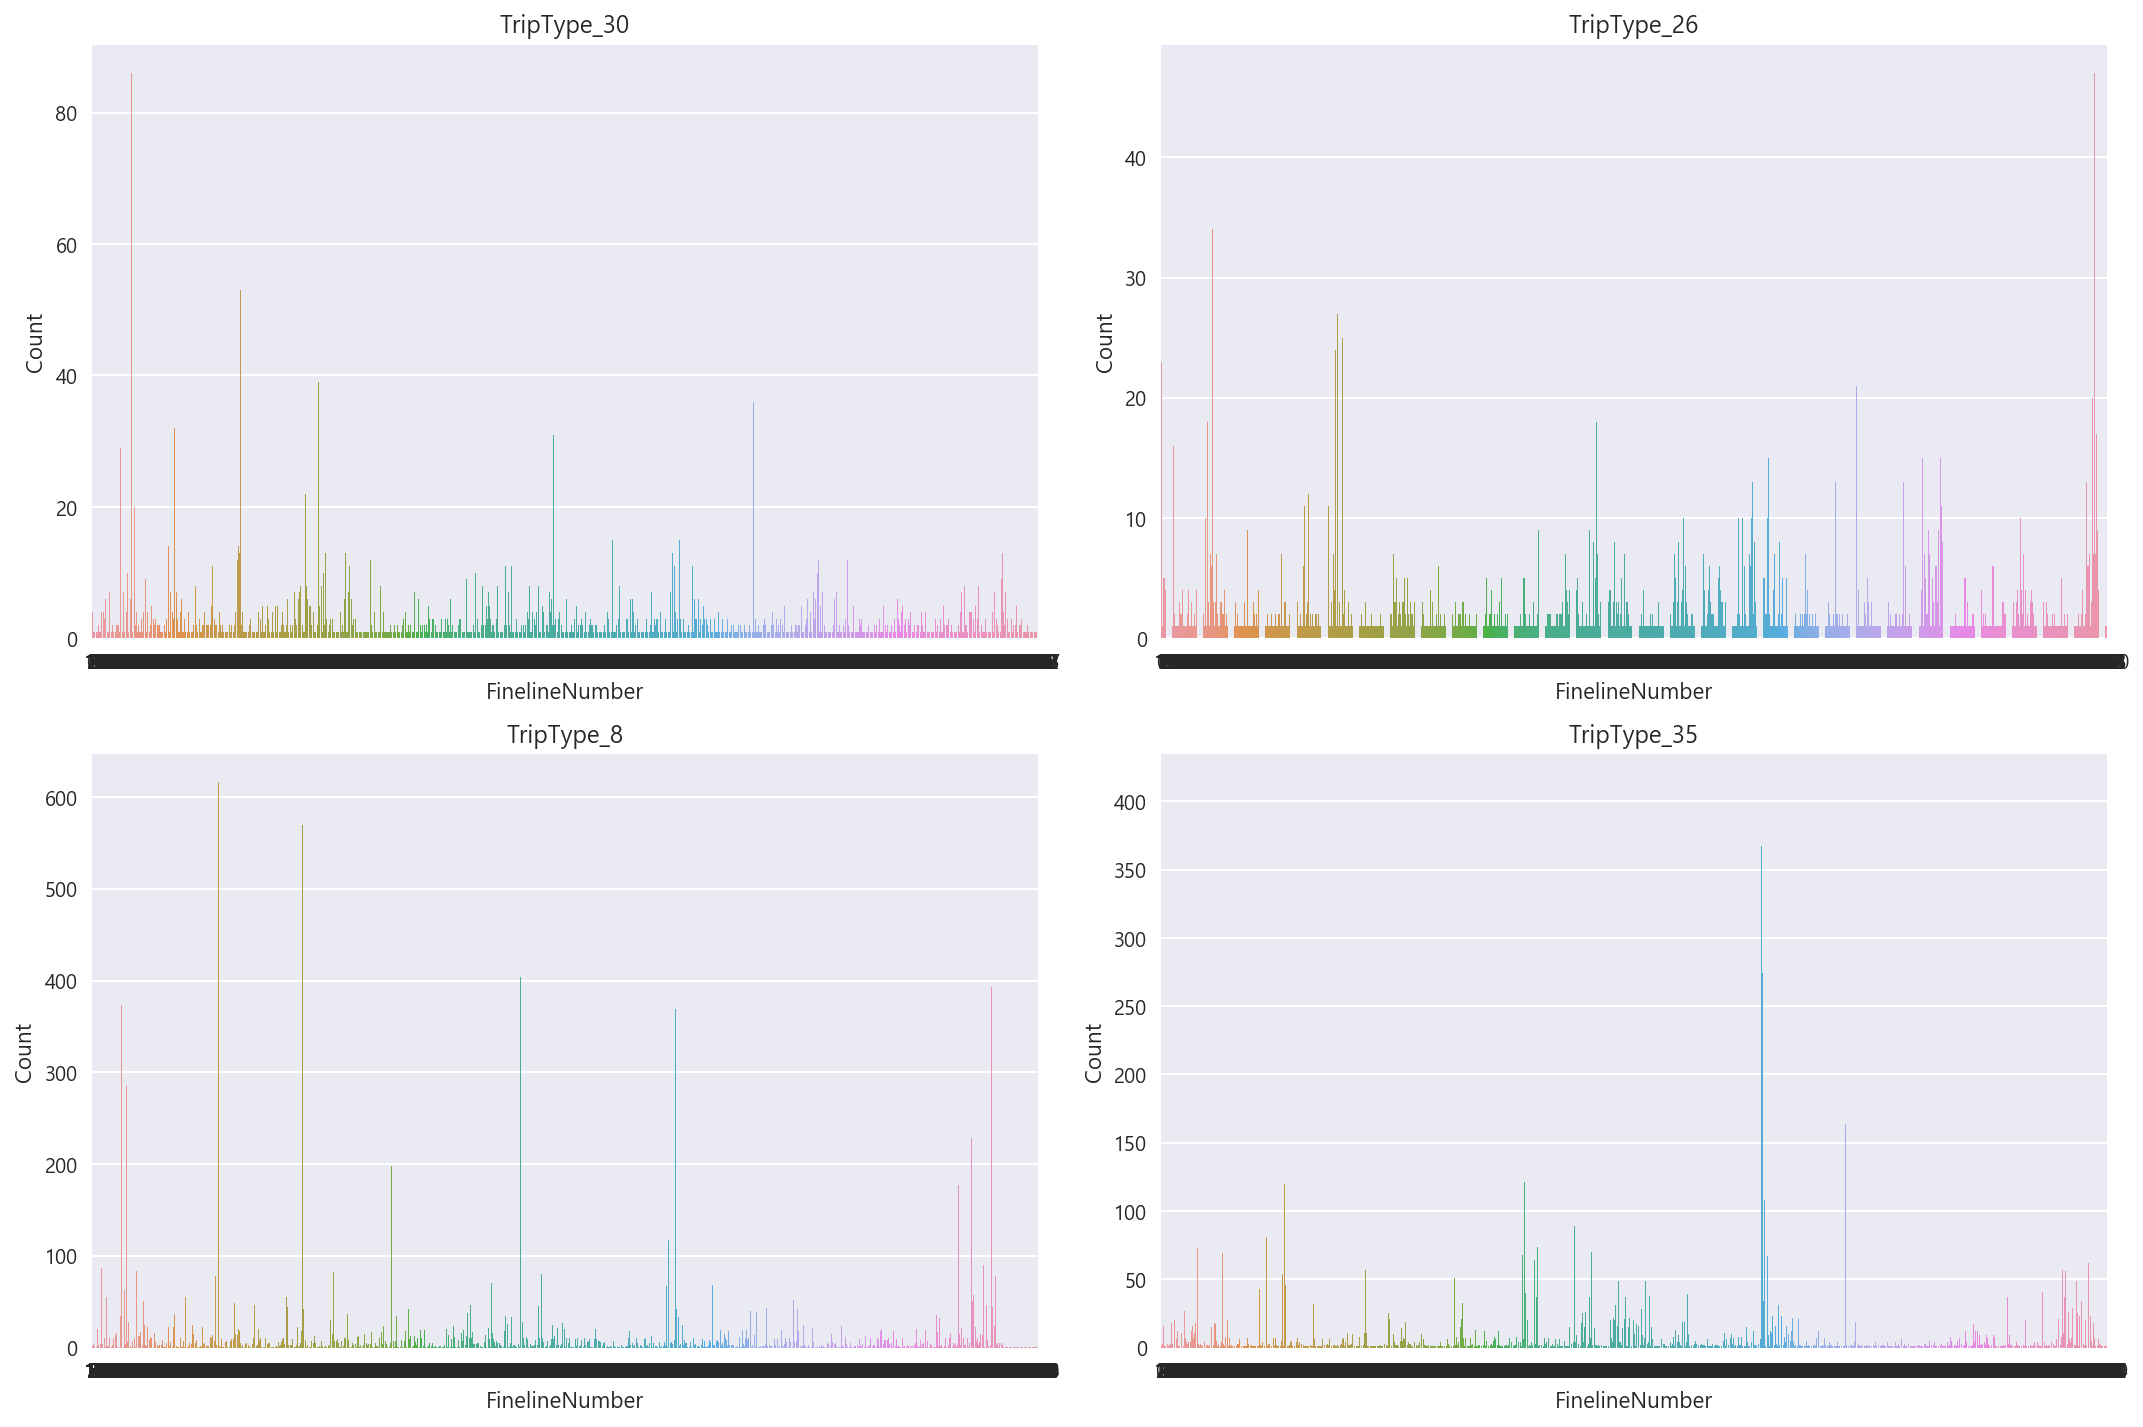

In [22]:
plt.figure(figsize=(15,10))
for i in range(1, 5):
    a = '22' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb2.loc[tt].index,y=gb2.loc[tt]["Count"], data=gb2.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [23]:
mhf = pd.read_csv('Musthave_by_FinelineNumber.csv')
mhf.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191343,6.0,6.0,6.0,7.0,9.0,4.0,9.0,9.0,1.0,...,8.0,7.0,7.0,9.0,9.0,8.0,9.0,9.0,9.0,0.0
95670,191344,3.0,3.0,4.0,3.0,3.0,4.0,5.0,0.0,0.0,...,4.0,0.0,4.0,5.0,4.0,4.0,5.0,3.0,5.0,0.0
95671,191345,8.0,2.0,15.0,5.0,13.0,10.0,7.0,9.0,0.0,...,14.0,13.0,13.0,17.0,17.0,13.0,17.0,11.0,17.0,4.0
95672,191346,1.0,4.0,14.0,11.0,17.0,14.0,14.0,10.0,0.0,...,15.0,16.0,17.0,17.0,16.0,11.0,14.0,15.0,17.0,0.0
95673,191347,0.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0


In [36]:
train_v1 = pd.read_csv("train_v1.csv")
train_v1.tail()

,Unnamed: 0,TripType,VisitNumber,Weekday,ScanCount,DepartmentDescription,FinelineNumber,standard_upc,company_code,product_code
647049,647049,39,191346,Sunday,1,PHARMACY OTC,1118.0,323900017788,23900,01778
647050,647050,39,191346,Sunday,1,FROZEN FOODS,1752.0,078742053363,78742,05336
647051,647051,39,191346,Sunday,1,PRODUCE,4170.0,000000040723,040,72
647052,647052,8,191347,Sunday,1,DAIRY,1512.0,041900076641,41900,07664
647053,647053,8,191347,Sunday,1,GROCERY DRY GOODS,3600.0,038000596551,38000,59655


In [38]:
gb3 = train_le.groupby(by=["TripType", "company_code"]).size()
gb3 = pd.DataFrame(gb3)
gb3.rename(columns={0:"Count"}, inplace=True)

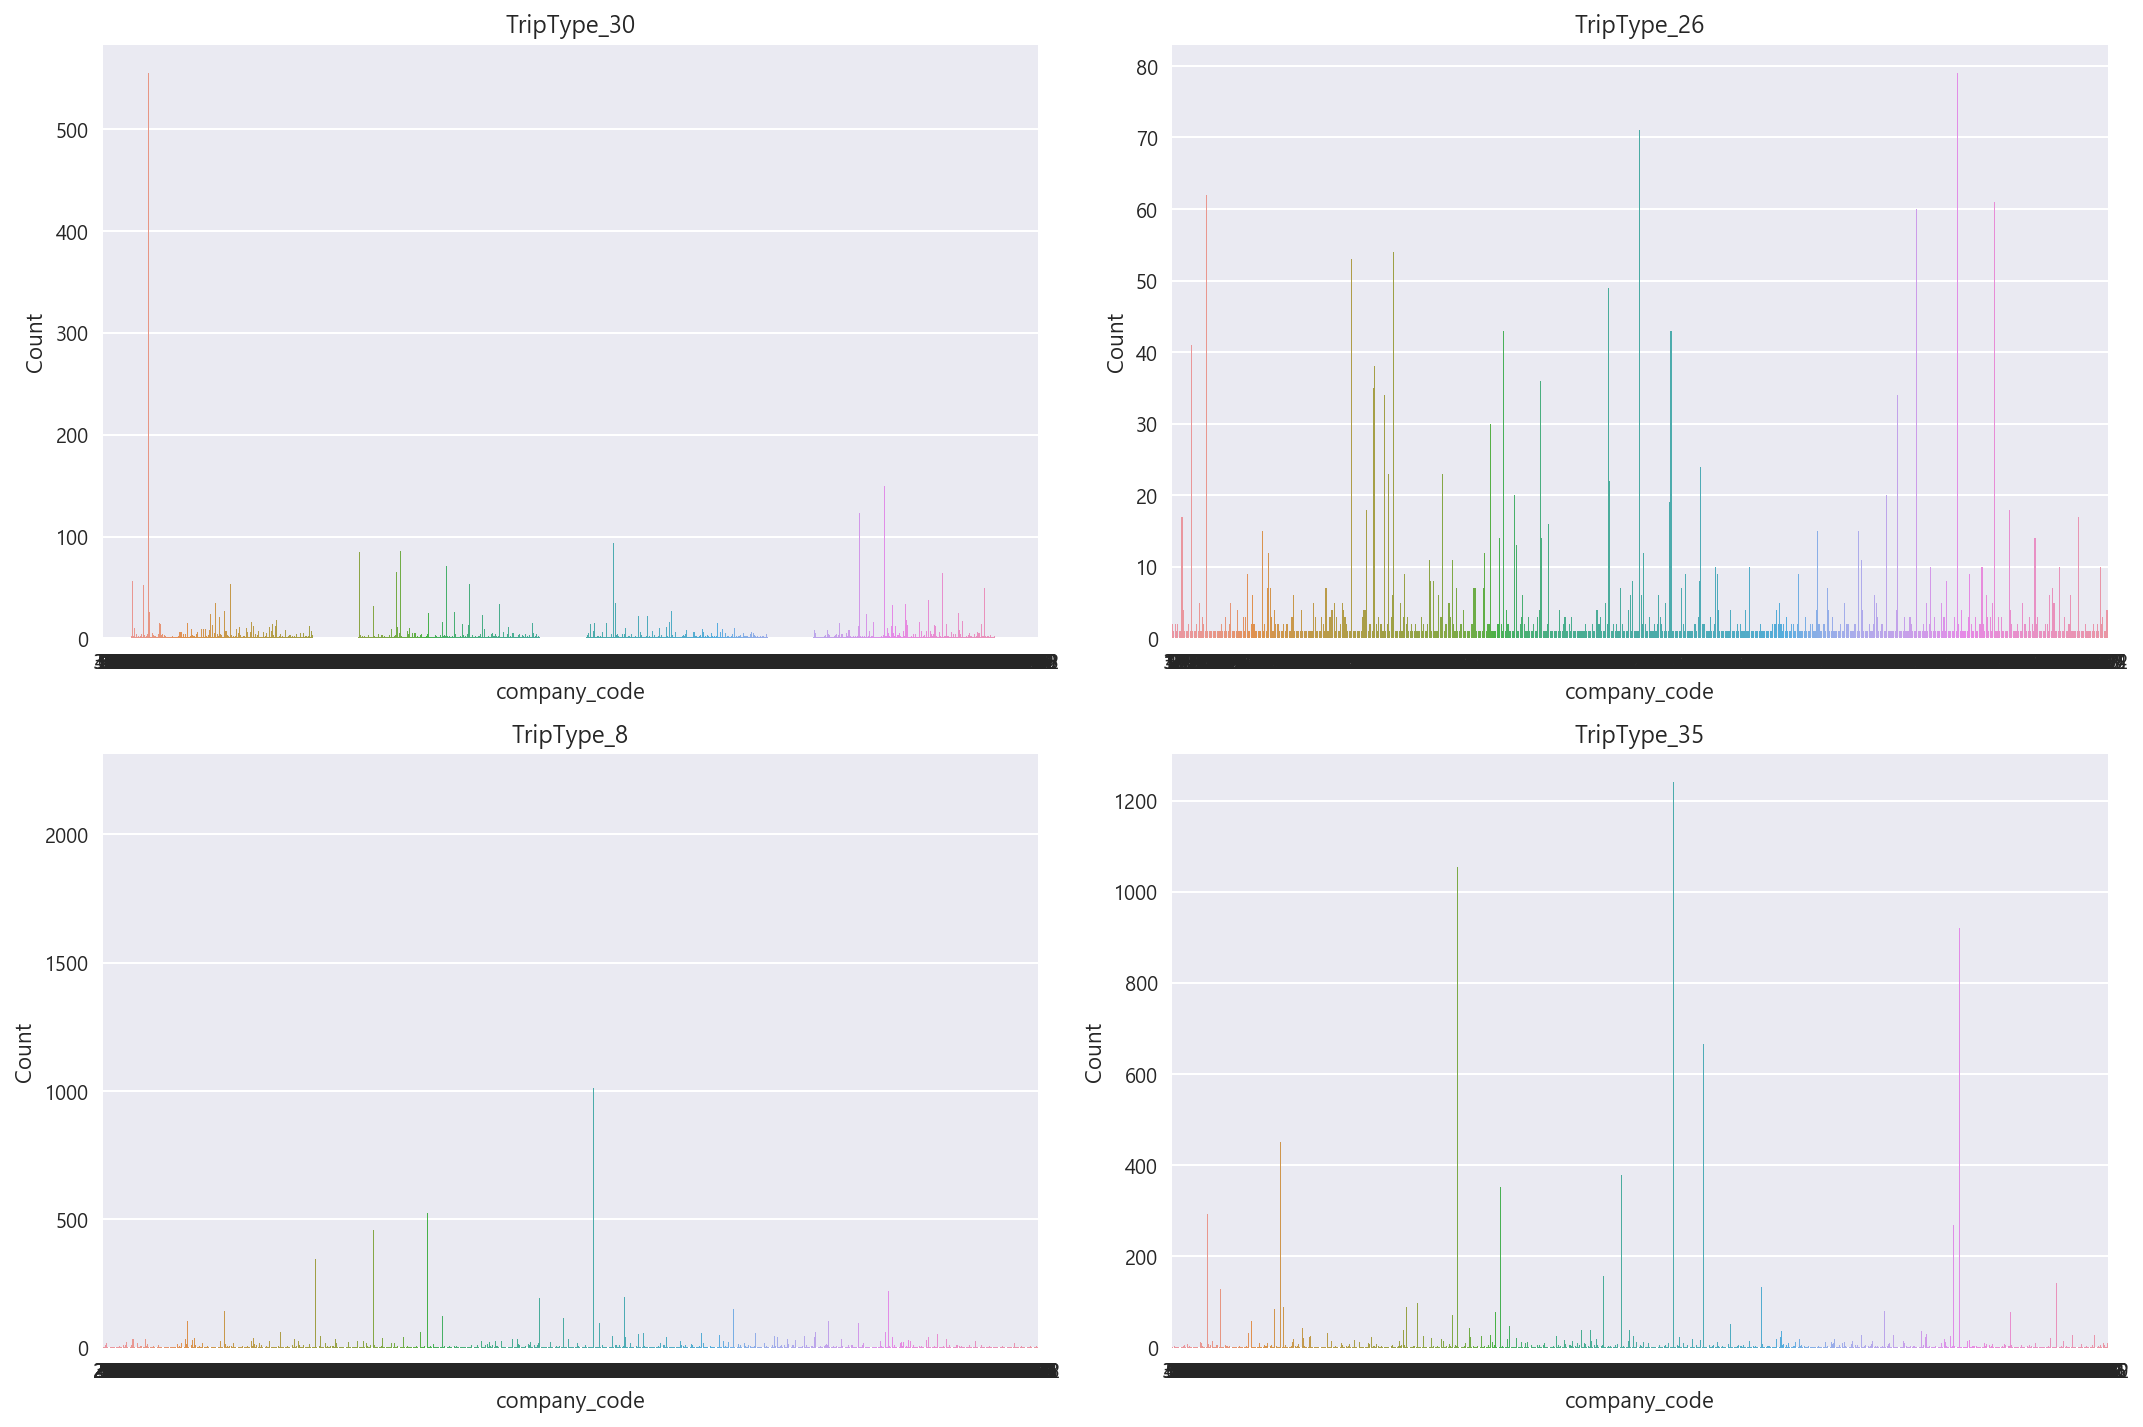

In [39]:
plt.figure(figsize=(15,10))
for i in range(1, 5):
    a = '22' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb3.loc[tt].index,y=gb3.loc[tt]["Count"], data=gb3.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [55]:
mhf = pd.read_csv('Musthave_by_company_code.csv')
mhf.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191343,7.0,6.0,8.0,6.0,6.0,5.0,9.0,7.0,1.0,...,9.0,8.0,7.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0
95670,191344,3.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,0.0,...,2.0,1.0,1.0,4.0,5.0,2.0,4.0,4.0,4.0,0.0
95671,191345,6.0,8.0,15.0,8.0,12.0,15.0,7.0,11.0,0.0,...,13.0,13.0,13.0,16.0,17.0,11.0,14.0,13.0,16.0,2.0
95672,191346,8.0,10.0,15.0,12.0,16.0,15.0,12.0,15.0,0.0,...,15.0,17.0,16.0,17.0,17.0,14.0,16.0,14.0,16.0,1.0
95673,191347,0.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0


In [58]:
gb4 = train_le.groupby(by=["TripType", "product_code"]).size()
gb4 = pd.DataFrame(gb4)
gb4.rename(columns={0:"Count"}, inplace=True)

In [ ]:
plt.figure(figsize=(15,10))
for i in range(1, 5):
    a = '22' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb4.loc[tt].index,y=gb4.loc[tt]["Count"], data=gb4.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [55]:
mhf = pd.read_csv('Musthave_by_product_code.csv')
mhf.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191343,7.0,6.0,8.0,6.0,6.0,5.0,9.0,7.0,1.0,...,9.0,8.0,7.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0
95670,191344,3.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,0.0,...,2.0,1.0,1.0,4.0,5.0,2.0,4.0,4.0,4.0,0.0
95671,191345,6.0,8.0,15.0,8.0,12.0,15.0,7.0,11.0,0.0,...,13.0,13.0,13.0,16.0,17.0,11.0,14.0,13.0,16.0,2.0
95672,191346,8.0,10.0,15.0,12.0,16.0,15.0,12.0,15.0,0.0,...,15.0,17.0,16.0,17.0,17.0,14.0,16.0,14.0,16.0,1.0
95673,191347,0.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0


-------------------

In [50]:
df = train[['TripType', 'VisitNumber']].groupby(['VisitNumber']).mean()
df.reset_index(inplace=True)
df = df.groupby("TripType").size()
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df.rename(columns={0:"Count"}, inplace=True)
df.sort_values(by=["Count"], ascending=False, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.tail()

,TripType,Count
33,19,375
34,4,346
35,12,269
36,23,139
37,14,4


In [51]:
df["Count"].describe()

count       38.000000
mean      2517.736842
std       3034.063074
min          4.000000
25%        585.750000
50%       1134.000000
75%       2981.750000
max      12161.000000
Name: Count, dtype: float64

<function matplotlib.pyplot.show>

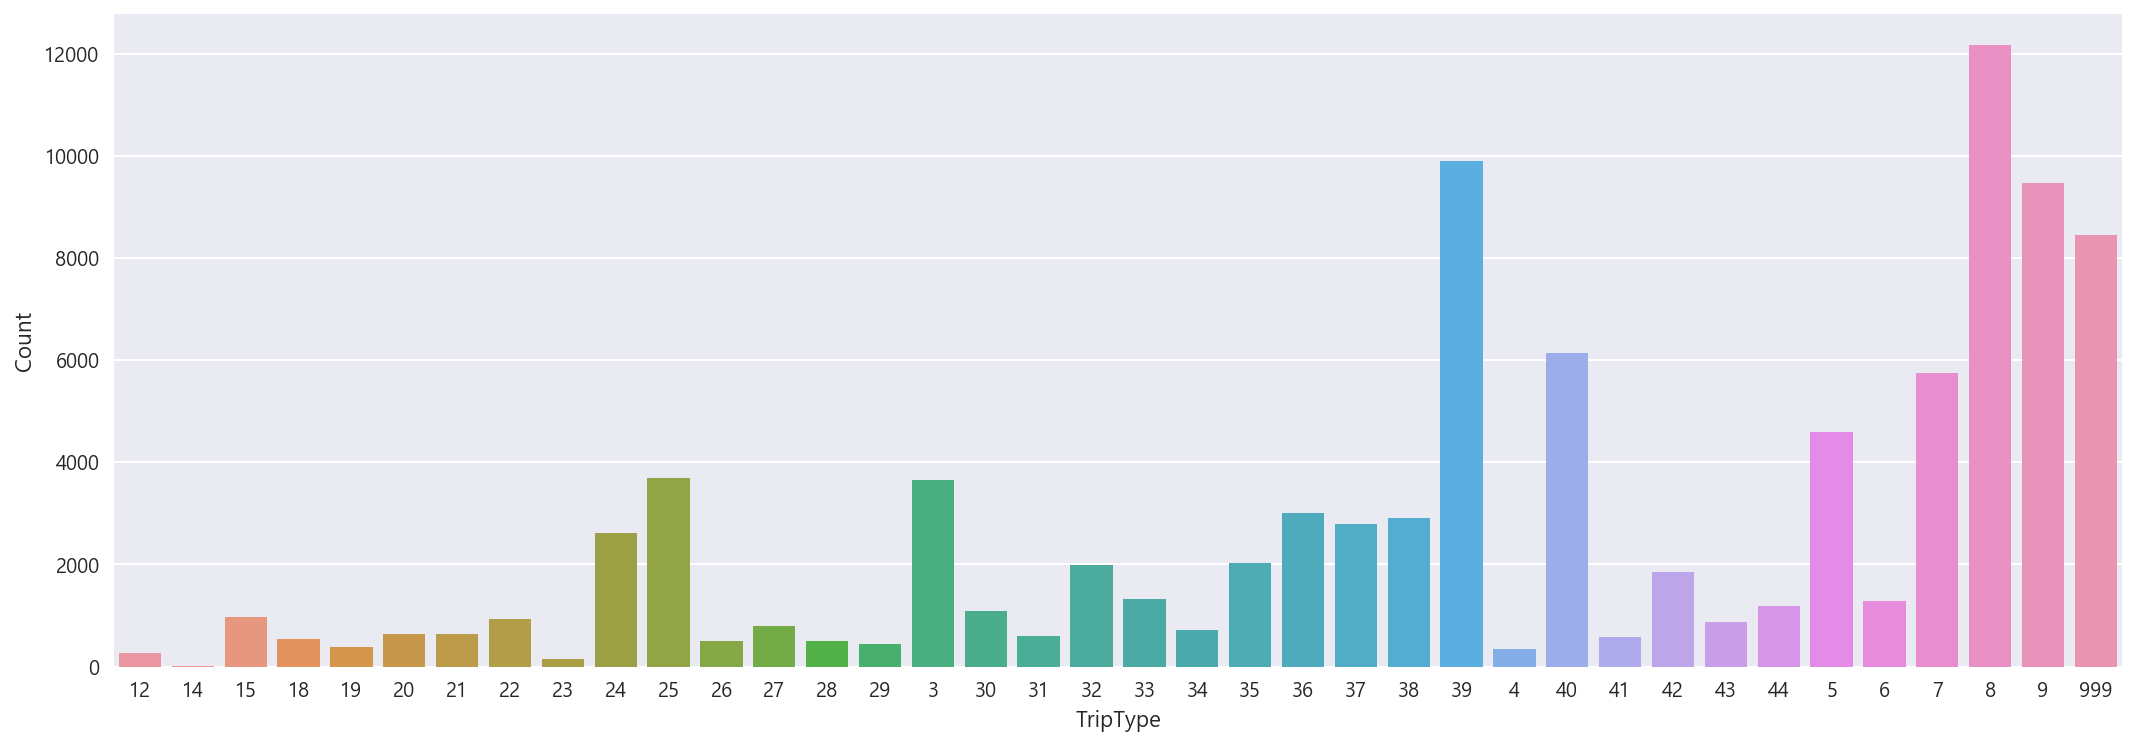

In [54]:
plt.figure(figsize=(18, 6))
sns.barplot(x=df["TripType"].astype(str), y=df2["Count"])
plt.show